# Mastering Scene Understanding: Scene Graphs to the Rescue

## Human-Object Interaction HOI


---

The following is an adaptation heavily based on the [official implementation](https://github.com/fredzzhang/spatially-conditioned-graphs) for the paper:
> *Zhang, Frederic Z., Dylan Campbell, and Stephen Gould. "Spatially conditioned graphs for detecting human-object interactions." Proceedings of the IEEE/CVF International Conference on Computer Vision. 2021.* [[Paper]](http://openaccess.thecvf.com/content/ICCV2021/papers/Zhang_Spatially_Conditioned_Graphs_for_Detecting_Human-Object_Interactions_ICCV_2021_paper.pdf)


## Setup
### Downloading the official repo

In [ ]:
import os
if not os.path.isdir('spatially-conditioned-graphs'):
    !git clone https://github.com/fredzzhang/spatially-conditioned-graphs.git

Cloning into 'spatially-conditioned-graphs'...
remote: Enumerating objects: 1168, done.
remote: Counting objects: 100% (253/253), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 1168 (delta 156), reused 220 (delta 134), pack-reused 915 (from 1)
Receiving objects: 100% (1168/1168), 3.55 MiB | 7.45 MiB/s, done.
Resolving deltas: 100% (729/729), done.


### Installing package `pocket`
❗❗For compatibility with version 0.19 of torchvision, change line 165 of the file <br>`spatially-conditioned-graphs/pocket/models/faster_rcnn.py`

from:
```python
state_dict = models.utils.load_state_dict_from_url(
```

to:
```python
state_dict = torch.hub.load_state_dict_from_url(
```

In [ ]:
if not os.path.isdir('spatially-conditioned-graphs/pocket'):
    !git clone https://github.com/fredzzhang/pocket.git
    !pip install -e pocket
    !mv pocket/pocket spatially-conditioned-graphs
    !rm -rf pocket

Cloning into 'pocket'...
remote: Enumerating objects: 2483, done.
remote: Counting objects: 100% (423/423), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 2483 (delta 266), reused 383 (delta 244), pack-reused 2060 (from 1)
Receiving objects: 100% (2483/2483), 2.11 MiB | 5.50 MiB/s, done.
Resolving deltas: 100% (1646/1646), done.
Obtaining file:///content/pocket
  Preparing metadata (setup.py) ... done
  Running setup.py develop for pocket


### Download toy model

We're actually going to need 3 files:

* A toy model trained on VCOCO for this demonstration.
* Information on VCOCO to build the model:
    * list of objects
    * list of actions
    * dictionary `object_to_action`
* An example image

In [ ]:
if not os.path.isfile('ckpt_00584_01.pt'):
    !gdown 1p4T7aTyUHVuzO1LsBGDLPyqqh_t24-sl
    !gdown 1aIYdFSBXD8EipU7ME7ZZZEbc7AgE712c
    !gdown 1zFlB7ohTjEFRTiNypdhFL332kVb9YCAQ

Downloading...
From (original): https://drive.google.com/uc?id=1p4T7aTyUHVuzO1LsBGDLPyqqh_t24-sl
From (redirected): https://drive.google.com/uc?id=1p4T7aTyUHVuzO1LsBGDLPyqqh_t24-sl&confirm=t&uuid=6d3025b7-b899-4d9b-89c4-55805796c0eb
To: /content/ckpt_00584_01.pt
100% 647M/647M [00:30<00:00, 21.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aIYdFSBXD8EipU7ME7ZZZEbc7AgE712c
To: /content/image.jpg
100% 32.9k/32.9k [00:00<00:00, 53.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zFlB7ohTjEFRTiNypdhFL332kVb9YCAQ
To: /content/coco_annotation_header.json
100% 2.71k/2.71k [00:00<00:00, 14.9MB/s]


### Move to the source code folder

In [ ]:
%cd spatially-conditioned-graphs

/content/spatially-conditioned-graphs


## Demonstration

Let's start with all the imports and loading an example image.

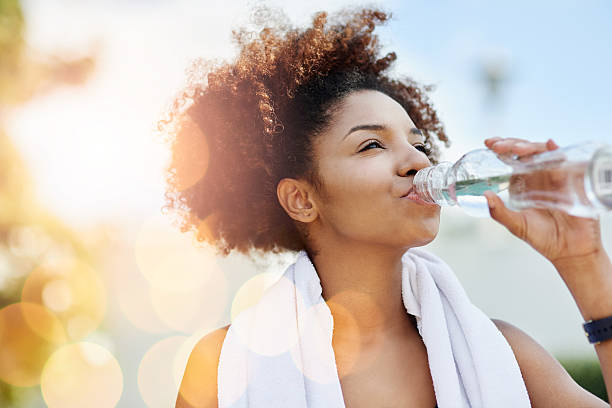

In [ ]:
## imports
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as peff
%matplotlib inline

import torch
import torchvision
from pocket import ops
from pocket.models.faster_rcnn import fasterrcnn_resnet_fpn
from models import SpatiallyConditionedGraph as SCG

im = Image.open('../image.jpg')
im

### Extracting object detections

The demonstration we are using requires feeding both the image and the corresponding annotations. This is a great opportunity for us to understand a little bit about the task!

So lets start by running an off-the-shelf object detection model and saving its inferences.

1 0.9919098019599915
1 0.9737966060638428
40 0.7792510986328125


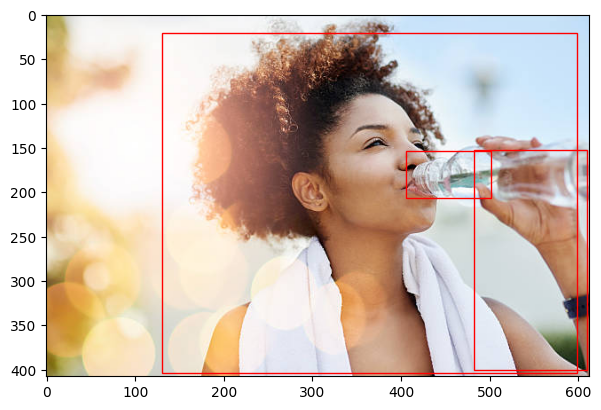

In [ ]:
### Detect COCO bounding boxes from image
detector = fasterrcnn_resnet_fpn('resnet50',
    pretrained=True,
    box_score_thresh=0.05,
    box_nms_thresh=0.5,
    box_detections_per_img=100
)
detector.eval()
detector.cuda()

image = torchvision.transforms.functional.to_tensor(im).cuda()
with torch.no_grad():
	detections = detector([image])[0]

detections['boxes'] = detections['boxes'].tolist()
detections['scores'] = detections['scores'].tolist()
detections['labels'] = detections['labels'].tolist()

### save detections
with open('../detections.json', 'w') as fp:
    json.dump(detections, fp)

### Visualize detections
fig, ax = plt.subplots(figsize=(7,7))
boxes_h, boxes_o, objects = [], [], [] # lists to feed the target on the next cell
for box, label, score in zip(detections['boxes'], detections['labels'], detections['scores']):
    if score < 0.7: continue

    if label == 1:
        boxes_h.append(box)
    else:
        boxes_o.append(box)
        objects.append(label)

    print(label, score)
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.imshow(im)

### Inputs and Targets

In [ ]:
### input
image = ops.to_tensor(im, 'pil')

### target detections with scores
with open('../detections.json', 'r') as f: # boxes, scores, labels
    detection = ops.to_tensor(json.load(f),input_format='dict')

### target triplets (human, object, action)
target = {
    'boxes_h': torch.tensor([boxes_h[0]], dtype=int), # human  boxes
    'boxes_o': torch.tensor([boxes_o[0]], dtype=int), # object boxes
    'objects': torch.tensor([objects[0]], dtype=int)  # object classes
    'labels' : torch.tensor([20], dtype=int),         # actions (20 is 'drink' in VCOCO)
}

image = [image]; target = [target]; detection = [detection]

### Loading VCOCO Information

To build the HOI model, and later for a nice visualization of results, we need to know three things:
* The object classes
* The action classes
* A mapping of all the actions that can be associated with any given object

Luckly, we already downloaded a json file with all this information. Let's load it into an object now.

In [ ]:
with open('../coco_annotation_header.json', 'r') as fp:
    vcoco_classes = json.load(fp)
vcoco_classes['object_to_action'] = {int(k): v for k, v in vcoco_classes['object_to_action'].items()}

print('objects:', vcoco_classes['objects'])
print('actions:', vcoco_classes['actions'])
print('object_to_action:', vcoco_classes['object_to_action'])

objects: ['background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
actions: ['hold obj', 'sit instr', 'ride instr', 'look obj', 'hit instr', 'hit obj', 'eat obj', 'eat instr', 'jump 

### Building and running HOI Model

In [ ]:
net = SCG(
    vcoco_classes['object_to_action'],
    human_idx=1,
    num_iterations=2,
    box_score_thresh=0.7,
    num_classes=len(vcoco_classes['actions'])
)
net.eval()

checkpoint = torch.load('../ckpt_00584_01.pt', map_location="cuda:0")
net.load_state_dict(checkpoint['model_state_dict'])

# Model forward
output = net(image, detection, target)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' and 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-9-f2d64b360c75>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will 

<All keys matched successfully>

### Visualize output

4 tensor([0, 0, 2, 2])
4 tensor([2, 1, 0, 1])
16 tensor([ 0,  3, 11, 15,  0,  3, 11, 20,  0,  3, 11, 15,  0,  3, 11, 20])
16 tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])
4 tensor([0.2470, 0.5699, 0.1832, 0.3185], grad_fn=<SplitWithSizesBackward0>)
16 tensor([0.0416, 0.0556, 0.0015, 0.0056, 0.2739, 0.0392, 0.0127, 0.2252, 0.0111,
        0.0297, 0.0015, 0.0029, 0.1338, 0.0167, 0.0089, 0.0790],
       grad_fn=<MulBackward0>)

=> Action: 0 - hold obj
(0 , 2 ), score: 0.0416,  label: False
(0 , 1 ), score: 0.2739,  label: False
(2 , 0 ), score: 0.0111,  label: False
(2 , 1 ), score: 0.1338,  label: False

=> Action: 3 - look obj
(0 , 2 ), score: 0.0556,  label: False
(0 , 1 ), score: 0.0392,  label: False
(2 , 0 ), score: 0.0297,  label: False
(2 , 1 ), score: 0.0167,  label: False

=> Action: 11 - carry obj
(0 , 2 ), score: 0.0015,  label: False
(0 , 1 ), score: 0.0127,  label: False
(2 , 0 ), score: 0.0015,  label: False
(2 , 1 ), score: 0.0089,  label: False

=> Action: 15 -

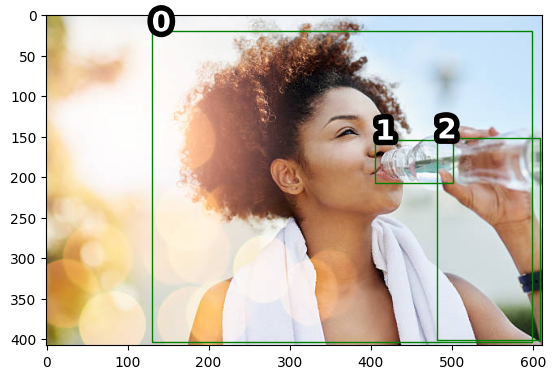

In [ ]:
def draw_boxes(ax, boxes):
    xy = boxes[:, :2].unbind(0)
    h, w = (boxes[:, 2:] - boxes[:, :2]).unbind(1)
    for i, (a, b, c) in enumerate(zip(xy, h.tolist(), w.tolist())):
        patch = patches.Rectangle(a.tolist(), b, c, facecolor='none', edgecolor='g')
        ax.add_patch(patch)
        txt = plt.text(*a.tolist(), str(i), fontsize=20, fontweight='semibold', color='w')
        txt.set_path_effects([peff.withStroke(linewidth=8, foreground='#000000')])
        plt.draw()

def visualise_entire_image(im, actions, output):
    """Visualise bounding box pairs in the whole image by classes"""
    bh=output['boxes_h']
    bo=output['boxes_o']
    no = len(bo)

    bbox, inverse = torch.unique(torch.cat([bo, bh]), dim=0, return_inverse=True)
    idxh = inverse[no:]
    idxo = inverse[:no]

    # Print predicted classes and scores
    scores = output['scores']
    weights = output['weights']
    prior = output['prior']
    index = output['index']
    pred = output['prediction']
    labels = output['labels']

    print(len(pred), pred)
    print(len(index), index)
    print(len(weights), weights)
    print(len(scores), scores)

    unique_actions = torch.unique(pred)
    for verb in unique_actions:
        print(f"\n=> Action: {verb} - {actions[verb]}")
        sample_idx = torch.nonzero(pred == verb).squeeze(1)
        for idx in sample_idx:
            b_idx = index[idx]
            print(
                f"({idxh[b_idx].item():<2}, {idxo[b_idx].item():<2}),",
                f"score: {scores[idx]:.4f}, ",
                # f"prior: {prior[0, idx]:.2f}, {prior[1, idx]:.2f}",
                f"label: {bool(labels[idx])}"
            )

    # Draw the bounding boxes
    fig = plt.figure()
    plt.imshow(im)
    ax = plt.gca()
    draw_boxes(ax, bbox)
    plt.show()

visualise_entire_image(im, vcoco_labels['actions'], output[0])